In [1]:
import pandas as pd
import numpy as np
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import gym
from gym import spaces

import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Excel 파일 및 시트 설정
folder_path = "xlsx"
file_names = [f"EIS_state_{i}.xlsx" for i in range(1, 6)]
sheets = ["25C", "35C", "45C"]

# 각 파일과 시트별 데이터프레임 로드 (열 이름 공백 제거, 컬럼명 변경, 불필요한 열 삭제)
for i, file_name in enumerate(file_names, start=1):
    file_path = os.path.join(folder_path, file_name)
    for sheet in sheets:
        var_name = f"df{i}_{sheet.replace('C', '')}"  # 예: df1_25, df1_35, df1_45
        df = pd.read_excel(file_path, sheet_name=sheet)
        df.columns = df.columns.str.replace(" ", "")
        df.rename(columns={'cyclenumber': 'cycle_number'}, inplace=True)
        df.drop(columns=["|Z|/Ohm", "Phase(Z)/deg"], errors='ignore', inplace=True)
        globals()[var_name] = df

In [4]:
# cycle_number별로 데이터를 텐서로 변환하는 함수
def group_and_convert_to_tensor(df, drop_cycle_number=True):
    tensor_dict = {}
    for cycle, group in df.groupby("cycle_number"):
        # cycle_number 열 제외 여부에 따라 데이터 선택
        if drop_cycle_number:
            group_data = group.drop(columns=['cycle_number']).values
        else:
            group_data = group.values
        # numpy array를 torch tensor로 변환 (dtype: float32)
        tensor_dict[cycle] = torch.tensor(group_data, dtype=torch.float32)
    return tensor_dict

# 모든 DataFrame에 대해 cycle_number별 텐서 데이터 생성
tensor_data_all = {}
for i in range(1, 6):
    for sheet in ['25', '35', '45']:
        df_name = f"df{i}_{sheet}"
        if df_name in globals():
            tensor_data_all[df_name] = group_and_convert_to_tensor(globals()[df_name])
        else:
            print(f"{df_name} not found.")

In [5]:
# ----- Dataset 클래스: 각 사이클을 개별 샘플로 구성 -----
class EISCycleDataset(Dataset):
    def __init__(self, tensor_data, target_length=60):
        """
        tensor_data: 이전에 생성한 데이터 딕셔너리. 각 key는 DataFrame 이름, value는 
                     {cycle_number: tensor (n, 3)} 형태.
        target_length: 각 사이클을 강제 맞출 시퀀스 길이. (padding/truncation 적용)
        """
        self.data = []
        self.target_length = target_length
        
        # 각 DataFrame의 모든 사이클을 하나의 리스트에 추가
        for df_key, cycles in tensor_data.items():
            cycle_keys = sorted(cycles.keys())
            for cycle in cycle_keys:
                tensor = cycles[cycle]  # 원래 (n, 3)
                if tensor.shape[0] < target_length:
                    pad_length = target_length - tensor.shape[0]
                    padded_tensor = torch.nn.functional.pad(tensor, (0, 0, 0, pad_length))
                    self.data.append(padded_tensor)
                else:
                    truncated_tensor = tensor[:target_length]
                    self.data.append(truncated_tensor)
                    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 반환 텐서의 shape: (60, 3)
        return self.data[idx]

In [6]:
# Dataset 및 DataLoader 생성 (예: batch_size 32)
dataset = EISCycleDataset(tensor_data_all, target_length=60)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
# ----- 전처리 및 역전처리 함수 -----
def transform_batch(batch):
    """
    batch: (B, 60, 3) 원본 데이터, 각 행: [freq, Re(Z), -Im(Z)]
    주파수 열에 대해 log₁₀ 변환 후 10으로 나누고,
    나머지 열은 그대로 유지합니다.
    """
    # 주파수 열: log₁₀ 변환 후 10으로 나누기
    freq = batch[:, :, 0:1]
    freq_transformed = torch.log10(freq + 1e-8) / 10.0  # 수치 안정성을 위해 작은 상수 추가
    # 나머지 열은 그대로 유지
    rest = batch[:, :, 1:3]
    return torch.cat([freq_transformed, rest], dim=2)

def inverse_transform_batch(transformed):
    """
    transformed: (B, 60, 3) 전처리된 데이터, 주파수 열은 log₁₀ 변환 후 10으로 나누어진 상태.
    역전처리: 주파수 열에 대해 (값 × 10)을 이용해 원본 주파수로 복원하고, 나머지 열은 그대로 반환합니다.
    """
    freq_transformed = transformed[:, :, 0:1]
    # 역전처리: log₁₀ 변환의 역연산은 10^(x*10)
    freq_recovered = 10 ** (freq_transformed * 10) - 1e-8
    rest = transformed[:, :, 1:3]
    return torch.cat([freq_recovered, rest], dim=2)


In [8]:
# 2. 내부 정규화 계층(BatchNorm1d)을 포함한 Conv1D AutoEncoder 모델 정의
class Conv1DAutoEncoder(nn.Module):
    def __init__(self, input_channels):
        super(Conv1DAutoEncoder, self).__init__()
        # Encoder: Conv1d + BatchNorm1d + ReLU
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=5, stride=2, padding=2),  # 60->30
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2),              # 30->15
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2),              # 15->8
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2),             # 8->4
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        # Decoder: ConvTranspose1d + BatchNorm1d + ReLU
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=5, stride=2, padding=2, output_padding=1),  # 4->8
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=2, output_padding=0),    # 8->15
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=2, output_padding=1),    # 15->30
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=input_channels, kernel_size=5, stride=2, padding=2, output_padding=1)  # 30->60
            # 최종 층에서는 활성화 함수 없이 출력합니다.
        )
        
    def forward(self, x):
        # x: (B, 60, 3) 를 (B, 3, 60)로 변환하여 Conv1d 적용
        x = x.permute(0, 2, 1)       # -> (B, 3, 60)
        x = self.encoder(x)          # -> (B, 128, 4)
        x = self.decoder(x)          # -> (B, 3, 60)
        x = x.permute(0, 2, 1)       # -> (B, 60, 3)
        return x

In [9]:
# 모델 초기화
input_channels = 3
ae_model = Conv1DAutoEncoder(input_channels).to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.AdamW(ae_model.parameters(), lr=0.001)

Epoch [10/200], Loss: 0.0009
Epoch [20/200], Loss: 0.0003
Epoch [30/200], Loss: 0.0002
Epoch [40/200], Loss: 0.0002
Epoch [50/200], Loss: 0.0001
Epoch [60/200], Loss: 0.0002
Epoch [70/200], Loss: 0.0002
Epoch [80/200], Loss: 0.0002
Epoch [90/200], Loss: 0.0001
Epoch [100/200], Loss: 0.0001
Epoch [110/200], Loss: 0.0001
Epoch [120/200], Loss: 0.0002
Epoch [130/200], Loss: 0.0001
Epoch [140/200], Loss: 0.0001
Epoch [150/200], Loss: 0.0001
Epoch [160/200], Loss: 0.0000
Epoch [170/200], Loss: 0.0001
Epoch [180/200], Loss: 0.0000
Epoch [190/200], Loss: 0.0001
Epoch [200/200], Loss: 0.0001


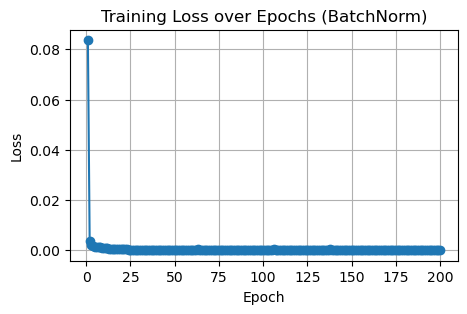

In [10]:
# 3. 학습 루프: 내부 정규화 계층을 활용한 학습
epochs = 200
loss_list = []

for epoch in range(epochs):
    ae_model.train()
    epoch_loss = 0.0
    batch_count = 0
    for batch in dataloader:
        optimizer.zero_grad()
        batch = batch.to(device)  # (B, 60, 3)
        # 간단 전처리: 주파수 열에 log10 변환 적용
        transformed = transform_batch(batch)
        outputs = ae_model(transformed)
        
        # 여기서는 모델 출력과 전처리된 입력 간의 MSE loss를 계산합니다.
        loss = criterion(outputs, transformed)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
        
    avg_loss = epoch_loss / batch_count
    loss_list.append(avg_loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# 학습 손실 시각화
plt.figure(figsize=(5,3))
plt.plot(range(1, len(loss_list)+1), loss_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs (BatchNorm)")
plt.grid(True)
plt.show()

In [11]:
torch.save(ae_model.state_dict(), "conv1dAE_pretrained.pth")

In [12]:
state_dict = torch.load("conv1dAE_pretrained.pth", map_location=device, weights_only=True)
ae_model.load_state_dict(state_dict)
ae_model.eval()

Conv1DAutoEncoder(
  (encoder): Sequential(
    (0): Conv1d(3, 16, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose1

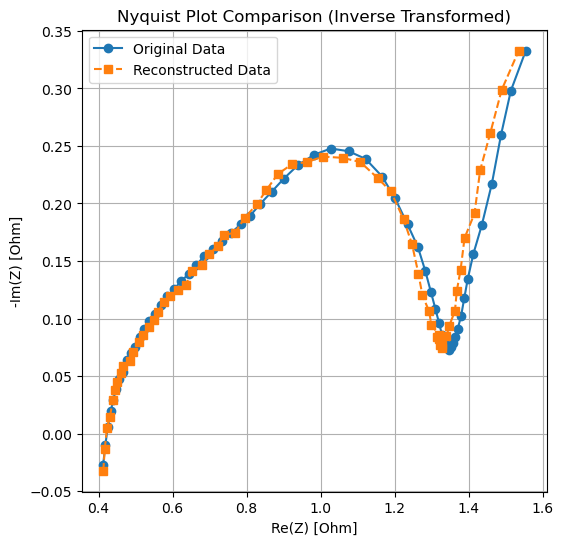

In [13]:
def plot_specific_cycle(dataset, sample_idx):
    """
    dataset: EISCycleDataset
    sample_idx: 플롯할 샘플 인덱스
    원본 데이터(측정값)와 모델이 재구성한 값을 역전처리하여 비교하는 Nyquist Plot을 그립니다.
    """
    # 원본 데이터 (측정 스케일): (60, 3)
    sample = dataset[sample_idx].to(device)
    
    # 전처리: 주파수 열에 대해 log10 변환 적용
    transformed = transform_batch(sample.unsqueeze(0))  # shape: (1, 60, 3)
    
    ae_model.eval()  # 내부 정규화 계층을 사용한 모델 예시 (ae_model)
    with torch.no_grad():
        output = ae_model(transformed)
    
    # inverse_transform_batch를 통해 모델 출력(전처리 상태)을 원본 스케일로 복원
    recovered = inverse_transform_batch(output)
    
    # NumPy 배열로 변환 (원본 데이터는 이미 측정 스케일)
    original_cycle = sample.detach().cpu().numpy()
    reconstructed_cycle = recovered[0].detach().cpu().numpy()
    
    # Nyquist Plot: Re(Z) vs. -Im(Z)
    plt.figure(figsize=(6,6))
    plt.plot(original_cycle[:, 1], original_cycle[:, 2], 'o-', label='Original Data')
    plt.plot(reconstructed_cycle[:, 1], reconstructed_cycle[:, 2], 's--', label='Reconstructed Data')
    plt.xlabel('Re(Z) [Ohm]')
    plt.ylabel('-Im(Z) [Ohm]')
    plt.title('Nyquist Plot Comparison (Inverse Transformed)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 예시: 데이터셋의 특정 사이클 플롯 (sample_idx 예: 4615)
plot_specific_cycle(dataset, sample_idx=5)

In [14]:
# AEWrapper: 인코더와 디코더를 분리하여 latent 벡터를 얻고 복원하는 기능 제공
class AEWrapper(nn.Module):
    def __init__(self, autoencoder):
        super(AEWrapper, self).__init__()
        self.encoder = autoencoder.encoder
        self.decoder = autoencoder.decoder
    def encode(self, x):
        # x: (B, 60, 3)
        x = x.permute(0, 2, 1)
        z = self.encoder(x)     # (B, 128, 4)
        return z.view(x.size(0), -1)  # (B, 512)
    def decode(self, z):
        # z: (B,512)
        z = z.view(-1, 128, 4)
        x = self.decoder(z)
        return x.permute(0, 2, 1)  # (B,60,3)

# AEWrapper 사용: 저장된 파라미터를 불러옴
ae_wrapper = AEWrapper(ae_model).to(device)
ae_wrapper.eval()


AEWrapper(
  (encoder): Sequential(
    (0): Conv1d(3, 16, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose1d(64, 32

In [15]:
# 1. 데이터 전처리 함수들
##############################################

def simulate_incomplete(sample, valid_indices):
    """
    sample: (60,3) 원본 사이클 데이터
    valid_indices: 유지할 인덱스 리스트 (예: [0,1,...,9])
    반환: (60,3) - valid_indices는 원본 값, 나머지는 0으로 채움.
    """
    incomplete = torch.zeros_like(sample)
    incomplete[valid_indices] = sample[valid_indices]
    return incomplete

def rmse_loss_impedance(recovered, ground_truth, eps=1e-6):
    """
    recovered, ground_truth: (B, N, 3) 텐서
      - 채널 0: 주파수, 채널 1: Re(Z), 채널 2: -Im(Z)
    복원 데이터와 ground truth에서 임피던스(실수 및 허수) 채널만 추출하여 RMSE 손실을 계산합니다.
    """
    # 임피던스 채널 추출 (채널 1과 2)
    rec_impedance = recovered[:, :, 1:3]
    gt_impedance = ground_truth[:, :, 1:3]
    
    mse = F.mse_loss(rec_impedance, gt_impedance, reduction='mean')
    rmse = torch.sqrt(mse + eps)
    return rmse

def get_weights(t, max_t):
    """
    t: 현재 학습 단계
    max_t: 총 학습 단계
    반환:
      w_gfv: L_GFV에 대한 가중치
      w_z: L_Z(기존 Chamfer loss)에 대한 가중치
    """
    ratio = min(t / max_t, 1.0)
    w_gfv = 1.0 - ratio
    w_z = ratio
    return w_gfv, w_z

def rmse_loss(x, y, eps=1e-6):
    # x나 y가 (1, 1, 512) 형태라면 불필요한 차원 제거
    x = x.squeeze(1) if x.ndim == 3 and x.shape[1] == 1 else x
    y = y.squeeze(1) if y.ndim == 3 and y.shape[1] == 1 else y
    mse = F.mse_loss(x, y, reduction='mean')
    rmse = torch.sqrt(mse + eps)
    return rmse


In [16]:
class EISCompletionEnv(gym.Env):
    """
    멀티 스텝 에피소드 환경:
      - 한 에피소드 내에서 전체 샘플(각 샘플은 (60,3))을 랜덤 순서로 처리.
      - 각 샘플마다 여러 action step을 통해 복원 결과가 원본 데이터와 일정 수준(Chamfer loss < threshold)까지 
        개선되거나, 최대 max_steps에 도달할 때까지 행동을 수행.
      - 상태(state)는 현재 샘플의 AE 인코딩된 latent 표현(1,512)을 flatten한 (512,) 벡터로 반환.
      - 보상은 GFV 손실, 재구성 손실의 동적 가중합의 음수입니다.
      - 각 step마다 info에 손실 값과 현재 샘플의 완료 여부(sample_done)를 반환합니다.
    """
    def __init__(self, dataset, ae_wrapper, generator, valid_indices, max_episodes, max_steps, threshold):
        super(EISCompletionEnv, self).__init__()
        self.dataset = dataset              # 각 샘플: (60,3) 텐서
        self.ae = ae_wrapper                # pre-trained AEWrapper (encoder, decoder)
        self.gen = generator                # trainable Generator
        self.valid_indices = valid_indices  # 예: [0,1,...,55]
        self.max_episodes = max_episodes      # 전체 에피소드 수
        self.max_steps = max_steps          # 한 샘플 당 최대 action step 수
        self.threshold = threshold          # 재구성 손실(L_Z)이 이 값 이하이면 샘플 완료로 판단
        
        # 상태: (1,512) → flatten하면 (512,)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(512,), dtype=np.float32)
        # 액션 공간: latent vector 차원이 512
        self.action_space = spaces.Box(low=-np.inf, high=np.inf, shape=(512,), dtype=np.float32)
        
        self.shuffled_indices = []
        self.current_sample_idx = 0
        self.current_step = 0

    def reset(self):
        self.shuffled_indices = np.random.permutation(len(self.dataset)).tolist()
        self.current_sample_idx = 0
        self.current_step = 0
        self.prev_total_loss = None
        
        # 샘플은 이제 (60,3) 형태
        sample = self.dataset[self.shuffled_indices[self.current_sample_idx]]  # (60,3)
        self.sample = sample
        self.gt = sample.to(device)  # ground truth
        
        # 불완전 데이터 생성: 개별 사이클에 대해 처리
        incomplete_cycle = simulate_incomplete(sample, self.valid_indices)  # (60,3)
        incomplete_input = incomplete_cycle.unsqueeze(0).to(device)  # (1,60,3)
        incomplete_preprocessed = transform_batch(incomplete_input)
        self.state = self.ae.encode(incomplete_preprocessed)  # (1,512)
        
        complete_preprocessed = transform_batch(self.gt.unsqueeze(0))  # (1,60,3)
        self.gt_encoded = self.ae.encode(complete_preprocessed).view(1,512)   # (1,512)
        
        return self.state.view(-1).detach().cpu().numpy()  # (512,)

    def step(self, action):
        # action: flatten된 (512,) 벡터 → (1,512) 텐서
        action_tensor = torch.tensor(action, dtype=torch.float32, device=device).unsqueeze(0)  # (1,512)
        self.last_action_tensor = action_tensor
        gen_latent = self.gen(action_tensor)  # (1,512)
        self.state = gen_latent  # 업데이트된 latent
        
        decoded = self.ae.decode(gen_latent)  # (1,60,3)
        
        L_GFV = rmse_loss(gen_latent, self.gt_encoded)
        L_Z = rmse_loss_impedance(decoded, self.gt.unsqueeze(0))  # (1,60,3) vs (1,60,3)
        
        w_gfv, w_z = get_weights(self.current_step, self.max_steps)
        total_loss = w_gfv * L_GFV + w_z * L_Z
        
        alpha = 10.0
        bonus_scale = 0.1
        
        if self.prev_total_loss is None:
            delta_loss = torch.tensor(0.0, device=total_loss.device)
        else:
            delta_loss = self.prev_total_loss - total_loss
        self.prev_total_loss = total_loss
        
        reward_base = torch.exp(alpha * delta_loss)-1
        dynamic_bonus = bonus_scale * max(0, self.threshold - L_Z.item())
        reward = reward_base + dynamic_bonus
        reward = reward.cpu().item()
        
        self.current_step += 1
        sample_done = (self.current_step >= self.max_steps) or (L_Z.item() < self.threshold)
        
        if sample_done:
            self.current_sample_idx += 1
            self.current_step = 0
            if self.current_sample_idx < len(self.shuffled_indices):
                sample = self.dataset[self.shuffled_indices[self.current_sample_idx]]
                self.sample = sample
                self.gt = sample.to(device)
                complete_preprocessed = transform_batch(self.gt.unsqueeze(0))
                self.gt_encoded = self.ae.encode(complete_preprocessed).view(1,512)
                incomplete_cycle = simulate_incomplete(sample, self.valid_indices)
                incomplete_input = incomplete_cycle.unsqueeze(0).to(device)
                incomplete_preprocessed = transform_batch(incomplete_input)
                self.state = self.ae.encode(incomplete_preprocessed)
                self.prev_total_loss = None
            else:
                done = True
                return self.state.view(-1).detach().cpu().numpy(), reward, done, {"L_GFV": L_GFV, "L_Z": L_Z}
        
        done = False
        next_state = self.state.view(-1).detach().cpu().numpy()  # (512,)
        info = {"L_GFV": L_GFV, "L_Z": L_Z, "sample_done": sample_done}
        
        return next_state, reward, done, info
        

In [17]:
# 상태 가치 함수 V(s; φ) 추정 (TD Actor-Critic에서 사용)
class ValueCritic(nn.Module):
    def __init__(self, state_dim: int):
        super(ValueCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.v_out = nn.Linear(256, 1)
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.v_out(x)
        return value

# Gaussian 정책을 따르는 Actor: π(a|s; θ)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.mean_layer = nn.Linear(256, action_dim)
        self.log_std_layer = nn.Linear(256, action_dim)
        # log_std_layer의 편향을 조정하여 초기 log_std 값을 높게 설정합니다.
        nn.init.constant_(self.log_std_layer.bias, -1.0)  # 기본값보다 높은 log_std
    
    def forward(self, state):
        """
        state: (B, state_dim) 텐서 (여기서 state_dim == latent_dim)
        residual을 예측하고, action = state + residual로 계산합니다.
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mean_layer(x)  # residual의 평균
        log_std = self.log_std_layer(x)
        log_std = torch.clamp(log_std, -10, 2)
        std = torch.exp(log_std)
        
        noise = torch.randn_like(mu)
        residual = mu + std * noise
        action = state + residual  # Residual connection: state + f(state)
        
        # 로그 확률은 residual 분포에 대해 계산 (action - state == residual)
        log_prob = -0.5 * (((residual - mu) / (std + 1e-8))**2 + 2 * log_std + np.log(2 * np.pi))
        log_prob = log_prob.sum(dim=1, keepdim=True)
        return action, log_prob

# Actor가 출력한 액션 (노이즈 벡터)를 받아 보정된 latent (Z-vector)를 생성.
class Generator(nn.Module):
    def __init__(self, action_dim, latent_dim):
        super(Generator, self).__init__()
        # 수정: 이제 action_dim과 latent_dim 모두 512를 가정합니다.
        # fc1의 출력 크기를 1024로 설정하고, fc2에서 최종 512 차원으로 매핑합니다.
        self.fc1 = nn.Linear(action_dim, 1024)
        self.fc2 = nn.Linear(1024, latent_dim)

    def forward(self, action):
        x = F.relu(self.fc1(action))
        latent = self.fc2(x)
        return latent


In [18]:
class ActorCriticGeneratorAgent:
    def __init__(self, state_dim, action_dim, latent_dim, ae_wrapper, actor_lr, critic_lr, gen_lr, gamma):
        self.actor = Actor(state_dim, action_dim).to(device)
        self.critic = ValueCritic(state_dim).to(device)
        self.generator = Generator(action_dim, latent_dim).to(device)
        self.ae = ae_wrapper
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gen_optimizer = optim.Adam(self.generator.parameters(), lr=gen_lr)
        
        self.gamma = gamma
    
    def select_action(self, state):
        """
        state: (B, state_dim)
        반환: action, log_prob (샘플링된 액션 및 로그 확률)
        """
        with torch.no_grad():
            action, log_prob = self.actor(state)
        return action, log_prob
    
    def update(self, state, action, log_prob, reward, next_state, done, info, current_episode, max_episodes, gt_encoded, gt):
        """
        단일 스텝 업데이트:
        
        1. Critic 업데이트:
           TD 오차 δ = r + γ * V(s') - V(s)를 이용해, Critic 손실(0.5*δ²)을 최소화.
        
        2. Actor 업데이트:
           TD 오차의 detach된 값을 곱한 log 확률의 평균을 최소화하여 정책을 개선.
        
        3. Generator 업데이트:
           환경에서 반환한 info 딕셔너리에 포함된 손실 값들을 이용해,
           동적 가중치(w_gfv, w_ch, w_slp)를 곱한 후, 그 합을 Generator의 손실로 사용.
           - w_gfv: 초반에는 1.0에서 점차 0.0으로 (latent 일치도)
           - w_ch: 초반에는 0.0에서 후반에 1.0으로 (재구성 손실)
           - w_slp: 상수 (예: 0.1)로 (기울기 일치도)
        
        인자는 모두 torch.Tensor이며, current_step와 max_step를 이용해 동적 가중치를 계산합니다.
        """
        # Critic 업데이트
        v_s = self.critic(state)             # (B,1)
        v_next = self.critic(next_state)       # (B,1)
        v_next = v_next * (1.0 - done)
        delta = reward + self.gamma * v_next - v_s  # TD 오차, (B,1)
        critic_loss = 0.5 * delta.pow(2).mean()
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward(retain_graph=True)
        self.critic_optimizer.step()
        
        # Actor 업데이트
        if not state.requires_grad:
            state.requires_grad_()
        sampled_action, new_log_prob = self.actor(state)
        actor_loss = -(delta.detach() * new_log_prob.sum(dim=1, keepdim=True)).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor_optimizer.step()
    
        # Generator 업데이트: 새로운 forward pass를 통해 독립적인 계산 그래프 생성
        # 먼저, ground truth 관련 텐서들은 detach()하여 계산 그래프와 분리합니다.
        gt_encoded = gt_encoded.detach()
        gt = gt.detach()
        
        # action을 detach()하여 새 forward pass 수행 (독립적 계산 그래프 생성)
        fresh_gen_latent = self.generator(action.detach())  # 이제 (1,512)로 직접 출력됨.
        fresh_decoded = self.ae.decode(fresh_gen_latent)       # (1,60,3)
        
        L_GFV_new = rmse_loss(fresh_gen_latent, gt_encoded)
        L_Z_new = rmse_loss_impedance(fresh_decoded, gt.unsqueeze(0))
    
        gen_loss = 0.5 * L_GFV_new + 0.5 * L_Z_new

        self.gen_optimizer.zero_grad()
        gen_loss.backward()
        self.gen_optimizer.step()
        
        return actor_loss.item(), critic_loss.item(), gen_loss.item()

In [19]:
##############################################
# 5. 환경 및 에이전트 생성
##############################################

# 1. valid_indices, 총 에피소드 수 설정 (cycle_idx는 더 이상 사용하지 않음)
valid_indices = list(range(2, 8)) + list(range(12, 18)) + list(range(22, 28)) + list(range(32, 38)) + list(range(42, 48)) + list(range(52, 58))
max_episodes = 10

# 3. 상태 및 액션 차원은 이제 개별 사이클의 AE 인코딩 결과인 (1,512)를 flatten하여 512로 설정
state_dim = 512      # 1 * 512
action_dim = 512     # 1 * 512
latent_dim = 512     # 1 * 512

# 4. Generator 생성 (수정된 차원 적용)
generator = Generator(action_dim, latent_dim).to(device)

# 5. Actor-Critic-Generator 에이전트 생성 (수정된 차원 적용)
agent = ActorCriticGeneratorAgent(state_dim, action_dim, latent_dim, ae_wrapper,
                                  actor_lr=1e-5, critic_lr=1e-5, gen_lr=1e-5, gamma=0.99)

# 7. 환경 생성  
#  수정된 EISCompletionEnv는 cycle_idx 파라미터를 받지 않으므로, 해당 인자는 제거합니다.
env = EISCompletionEnv(dataset, ae_wrapper, agent.generator, valid_indices, max_episodes, max_steps=3, threshold=0.001)

# 8. 생성된 환경 및 에이전트 확인
print("Environment and agent have been created.")
print("State space shape:", env.observation_space.shape)   # 예상: (512,)
print("Action space shape:", env.action_space.shape)         # 예상: (512,)


Environment and agent have been created.
State space shape: (512,)
Action space shape: (512,)


In [ ]:
# 6. 학습 루프
##############################################

num_episodes = max_episodes
episode_final_rewards = []  # 각 샘플의 최종 보상을 저장

for episode in range(num_episodes):
    # 초기 상태: 이제 (512,) numpy array (개별 사이클 기준)
    state_np = env.reset()  
    state = torch.tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)  # (1,512)
    done = False
    sample_final_rewards = []  # 에피소드 내 각 샘플의 최종 보상 저장
    
    while not done:
        # Actor에서 액션 및 로그 확률 샘플링
        action, log_prob = agent.select_action(state)
        
        # 환경 step: 액션을 numpy array로 변환하여 전달 (512, )
        action_np = action.detach().cpu().numpy().squeeze(0)
        next_state_np, reward, done, info = env.step(action_np)
        
        # 반환된 next_state를 텐서로 변환 (1,512)
        next_state = torch.tensor(next_state_np, dtype=torch.float32, device=device).unsqueeze(0)
        reward_t = torch.tensor([[reward]], dtype=torch.float32, device=device)
        done_t = torch.tensor([[1.0 if done else 0.0]], dtype=torch.float32, device=device)
        
        # TD Actor-Critic 및 Generator 업데이트
        actor_loss, critic_loss, gen_loss = agent.update(
            state, action, log_prob, reward_t, next_state, done_t, info,
            env.current_step, env.max_steps, env.gt_encoded, env.gt
        )
        
        # 상태 전이 및 에피소드 보상 누적
        state = next_state

        # sample_done 여부에 따라, 최종 보상인 경우 로그에 기록합니다.
        if info.get("sample_done", False):
            sample_final_rewards.append(reward)
            # print(f"Sample completed with final reward: {reward:.5f}")
        
    # 에피소드가 끝나면, 에피소드 내 각 샘플의 최종 보상 평균을 계산하여 저장
    if len(sample_final_rewards) > 0:
        episode_avg_reward = sum(sample_final_rewards) / len(sample_final_rewards)
    else:
        episode_avg_reward = 0.0
    episode_final_rewards.append(episode_avg_reward)
    
    print(f"[Episode {episode}] Final Sample Average Reward = {episode_avg_reward:.5f}")

# 학습 종료 후, 에피소드별 평균 보상 플롯
plt.figure(figsize=(8,6))
plt.plot(range(num_episodes), episode_final_rewards, label="Final Sample Average Reward")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Final Sample Average Reward per Episode")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def plot_nyquist_multi_steps(sample_index, max_steps_plot=None):
    """
    주어진 sample_index에 대해 환경을 reset한 후,
    RL 에이전트(Actor와 Generator)를 다중 스텝 실행하여 latent vector가 점진적으로 복원되는 과정을 추적하고,
    각 스텝마다 AE 디코더와 역전처리(inverse_transform_batch)를 통해 원본 스케일로 복원한 결과를 Nyquist 플롯으로 시각화합니다.
    
    매개변수:
      sample_index (int): 데이터셋에서 복원 과정을 시각화할 샘플의 인덱스.
      max_steps_plot (int, optional): 시각화할 최대 스텝 수. 지정하지 않으면 환경의 sample_done 또는 done 조건에 따라 중단됩니다.
    """
    # 환경을 reset하여 해당 샘플에 대한 에피소드를 시작합니다.
    # reset()은 flatten한 (512,) 벡터를 반환하며, 내부적으로 env.state는 (1,512)로 유지됩니다.
    state = env.reset()
    original = env.gt.detach().cpu().numpy()  # 원본 샘플 (60, 3)

    valid_indices = list(range(2, 8)) + list(range(12, 18)) + list(range(22, 28)) + \
                    list(range(32, 38)) + list(range(42, 48)) + list(range(52, 58))
    
    # 초기 상태에 대해 AE 디코더를 통해 복원된 결과 저장 (전처리 및 역전처리 적용)
    # env.state는 이미 (1,512) 형태이므로, unsqueeze 제거
    decoded = ae_wrapper.decode(env.state)  # (1, 60, 3)
    reconstructed = inverse_transform_batch(decoded)  # 복원 결과 (1, 60, 3)
    recon_list = [reconstructed[0].detach().cpu().numpy()]  # 리스트에 저장
    
    step_count = 0
    while True:
        # 상태(state)는 flatten한 latent (512,) 형태이므로, 배치 차원 추가
        current_state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)  # (1,512)
        # Actor가 액션 및 로그 확률을 선택합니다.
        action, _ = agent.actor(current_state)
        # 선택한 액션을 사용하여 환경의 step()을 수행합니다.
        next_state, reward, done, info = env.step(action.detach().cpu().numpy())
        state = next_state  # 상태 업데이트
        
        # 현재 env.state (latent 상태)를 AE 디코더로 복원하고, 역전처리하여 원본 스케일 복원
        # env.state는 이미 (1,512) 이므로 unsqueeze 없이 호출
        decoded = ae_wrapper.decode(env.state)
        reconstructed = inverse_transform_batch(decoded)
        recon_np = reconstructed[0].detach().cpu().numpy()
        recon_list.append(recon_np)
        
        step_count += 1
        # sample_done 또는 done 플래그가 True이면 중단
        if info.get("sample_done", False) or done:
            break
        if max_steps_plot is not None and step_count >= max_steps_plot:
            break

    # 여러 스텝에 걸친 복원 결과를 Nyquist 플롯으로 시각화합니다.
    plt.figure(figsize=(10,8))
    for i, recon_np in enumerate(recon_list):
        plt.plot(recon_np[:, 1], recon_np[:, 2], marker='o', linestyle='-', label=f'Step {i}')
    # 원본 데이터를 검정 점선으로 표시
    plt.plot(original[:, 1], original[:, 2], 'k--', label='Original')
    plt.xlabel('Re(Z) [Ohm]')
    plt.ylabel('-Im(Z) [Ohm]')
    plt.title('Nyquist Plot over Multiple RL Steps')
    plt.legend()
    plt.grid(True)
    plt.show()


# 사용 예:
# 유효 인덱스를 전역 변수 valid_indices_global에 할당 (이전 정의된 valid_indices 사용)
valid_indices_global = valid_indices
# 데이터셋에서 복원 과정을 확인할 샘플 인덱스 예시 (예: 4615)
plot_nyquist_multi_steps(sample_index=0, max_steps_plot=2)

In [ ]:
from tqdm import tqdm  # 진행률 표시줄을 위한 라이브러리 (선택사항)

def evaluate_model_performance(dataset, env, agent, device):
    """
    dataset: 각 샘플이 (60,3) 텐서 형식으로 구성된 데이터셋
    env: EISCompletionEnv 인스턴스
    agent: ActorCriticGeneratorAgent 인스턴스
    device: 계산에 사용되는 디바이스 (GPU 또는 CPU)
    
    반환:
      mse_avg: 전체 샘플에 대한 임피던스(MSE)의 평균 값
    """
    mse_total = 0.0
    sample_count = len(dataset)
    
    # 평가 모드로 전환 (gradient 계산 불필요)
    agent.actor.eval()
    agent.critic.eval()
    agent.generator.eval()
    
    # dataset 내 각 샘플에 대해 평가
    for i in tqdm(range(sample_count), desc="Evaluating Samples"):
        # 1. 샘플 및 ground truth 준비
        sample = dataset[i]                  # (60,3)
        gt = sample.to(device)               # ground truth
        
        # 2. 불완전한 데이터 생성 (손실된 샘플 시뮬레이션)
        incomplete_cycle = simulate_incomplete(sample, env.valid_indices)  # (60,3)
        incomplete_input = incomplete_cycle.unsqueeze(0).to(device)          # (1,60,3)
        incomplete_preprocessed = transform_batch(incomplete_input)          # 전처리
        
        # 3. AE 인코더를 통해 초기 latent 상태 획득
        state = env.ae.encode(incomplete_preprocessed)  # (1,512)
        
        # 4. RL 기반 복원 과정: 최대 env.max_steps 또는 샘플 완료(sample_done)가 될 때까지 진행
        done = False
        while not done:
            # 에이전트로부터 액션 및 로그 확률을 샘플링 (평가 시 gradient 기록 불필요)
            action, _ = agent.select_action(state)
            action_np = action.detach().cpu().numpy().squeeze(0)  # (512,)
            
            # 환경에 액션 전달하여 다음 상태 및 완료 여부 획득
            next_state_np, reward, done, info = env.step(action_np)
            state = torch.tensor(next_state_np, dtype=torch.float32, device=device).unsqueeze(0)
        
        # 5. 최종 latent 상태(state)로부터 복원 결과 생성 (AE 디코더 사용)
        reconstructed = env.ae.decode(state)   # (1,60,3)
        
        # 6. 원본 gt와 복원된 결과의 임피던스 채널 비교 (채널 1, 2)
        mse_sample = F.mse_loss(reconstructed[:, :, 1:3], gt.unsqueeze(0)[:, :, 1:3], reduction='mean').item()
        mse_total += mse_sample

    mse_avg = mse_total / sample_count
    return mse_avg

# 사용 예시:
mse_avg = evaluate_model_performance(dataset, env, agent, device)
print("Average MSE over all samples:", mse_avg)